***
# **Small-MOCCA: MLTrees Regression Training**

***
Feature exploration, optmization and training of traditional ML models for $M_{MMO}$ estimation.  

> Programs by J.Saavedra-Bastidas.
***

In [1]:
# General Libraries ---------------------------------------------------------------------------------------------#
import os
import sys
import argparse
import yaml
import torch 

import numpy  as np
import pandas as pd
#----------------------------------------------------------------------------------------------------------------#

In [2]:
# Change to working directory -----------------------------------------------------------------------------------#
os.chdir("../")
#----------------------------------------------------------------------------------------------------------------#

In [3]:
# External functions and utilities ------------------------------------------------------------------------------#
from loguru          import logger
from dataclasses     import dataclass
from datetime        import datetime
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
#----------------------------------------------------------------------------------------------------------------#

In [4]:
# Custom functions ----------------------------------------------------------------------------------------------#
from src.processing.format        import tabular_features
from src.optim.optimizer          import SpaceSearch, SpaceSearchConfig
from src.utils.directory          import load_yaml_dict
from src.utils.visualize          import correlation_plot, residual_plot
from src.models.mltrees.regressor import MLTreeRegressor
#----------------------------------------------------------------------------------------------------------------#

In [5]:
# Set data partition paths --------------------------------------------------------------------------------------#
train_datapath = "datasets/downsample/moccasurvey/0_fold/train.csv"
val_datapath   = "datasets/downsample/moccasurvey/0_fold/val.csv"
test_datapath  = "datasets/downsample/moccasurvey/test.csv"

# Set features and targets
contfeats = ["log(t)", "log(t_coll/t_cc)" ,"M_tot/M_crit", "log(rho(R_h))", "log(R_h/R_core)"]
catfeats  = ["type_sim"]
target    = ["M_MMO/M_tot"]
#----------------------------------------------------------------------------------------------------------------#

In [6]:
# Prepare the training and validation data features -------------------------------------------------------------#
train_df = pd.read_csv(train_datapath, index_col=False)
val_df   = pd.read_csv(val_datapath, index_col=False)
test_df  = pd.read_csv(test_datapath, index_col=False)

 # Extract features and target
feature_names  = contfeats + catfeats + target

# Training
feats_train, feats_names = tabular_features(train_df, names=feature_names, return_names=True, onehot=False)

# Identify continuous and categorical and target columns   
cont_columns   = [col for col in feats_train.columns if col in contfeats]
cat_columns    = [col for col in feats_train.columns if any(col.startswith(cf) for cf in catfeats)] 
target_columns = [col for col in feats_train.columns if col in target]

# Extract elements
X_train = feats_train[cont_columns+cat_columns]
y_train = feats_train[target_columns[0]]

# Validation
feats_val, _ = tabular_features(val_df, names=feature_names, return_names=True, onehot=False)

X_val = feats_val[cont_columns+cat_columns]
y_val = feats_val[target_columns[0]]

# Validation
feats_test, _ = tabular_features(test_df, names=feature_names, return_names=True, onehot=False)

X_test = feats_test[cont_columns+cat_columns]
y_test = feats_test[target_columns[0]]

print(f"- Training features (Xtrain type={type(X_train)}): {len(X_train)} [{np.shape(X_train)}]")
print(f"- Training targets  (ytrain type={type(y_train)}): {len(y_train)} [{np.shape(y_train)}]")
print(f"- Validation features (Xval type={type(X_val)}): {len(X_val)} [{np.shape(X_val)}]")
print(f"- Validation targets  (yval type={type(y_val)}): {len(y_val)} [{np.shape(y_val)}]")
print(f"- Test features (Xtest type={type(X_test)}): {len(X_test)} [{np.shape(X_test)}]")
print(f"- Test targets  (ytest type={type(y_test)}): {len(y_test)} [{np.shape(y_test)}]")
#----------------------------------------------------------------------------------------------------------------#

- Training features (Xtrain type=<class 'pandas.core.frame.DataFrame'>): 2330357 [(2330357, 6)]
- Training targets  (ytrain type=<class 'pandas.core.series.Series'>): 2330357 [(2330357,)]
- Validation features (Xval type=<class 'pandas.core.frame.DataFrame'>): 892772 [(892772, 6)]
- Validation targets  (yval type=<class 'pandas.core.series.Series'>): 892772 [(892772,)]
- Test features (Xtest type=<class 'pandas.core.frame.DataFrame'>): 340052 [(340052, 6)]
- Test targets  (ytest type=<class 'pandas.core.series.Series'>): 340052 [(340052,)]


In [7]:
# Initialize optimizer with configuration
config    = SpaceSearchConfig(model_type = "xgboost", 
                              n_jobs     = 20, 
                              n_trials   = 100, 
                              device     = "cuda", 
                              seed       = 42)
optimizer = SpaceSearch(config)

# Create study name
study_name = f"proof_of_concepts"

#----------------------------------------------------------------------------------------------------------------#

/opt/conda/lib/python3.11/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
2025-09-13 16:57:45,422 - SpaceSearch - INFO - SpaceSearch initialized for xgboost model (device=cuda)


[I 2025-09-13 16:57:45,457] A new study created in memory with name: proof_of_concepts
[I 2025-09-13 16:57:55,112] Trial 0 finished with value: 3805.603230334711 and parameters: {'tweedie_variance_power': 1.39963209507789, 'learning_rate': 0.22648248189516848, 'num_leaves': 192, 'min_child_samples': 62, 'feature_fraction': 0.4936111842654619, 'bagging_fraction': 0.49359671220172163, 'bagging_freq': 1, 'n_estimators': 900, 'max_depth': 10, 'lambda_l1': 3.540362888980227, 'lambda_l2': 0.10292247147901223}. Best is trial 0 with value: 3805.603230334711.
[I 2025-09-13 16:57:57,535] Trial 1 finished with value: 3890.572685611235 and parameters: {'tweedie_variance_power': 1.8759278817295955, 'learning_rate': 0.11536162338241392, 'num_leaves': 64, 'min_child_samples': 22, 'feature_fraction': 0.5100427059120604, 'bagging_fraction': 0.5825453457757226, 'bagging_freq': 6, 'n_estimators': 500, 'max_depth': 6, 'lambda_l1': 3.0592644736118975, 'lambda_l2': 0.6974693032602092}. Best is trial 0 with 

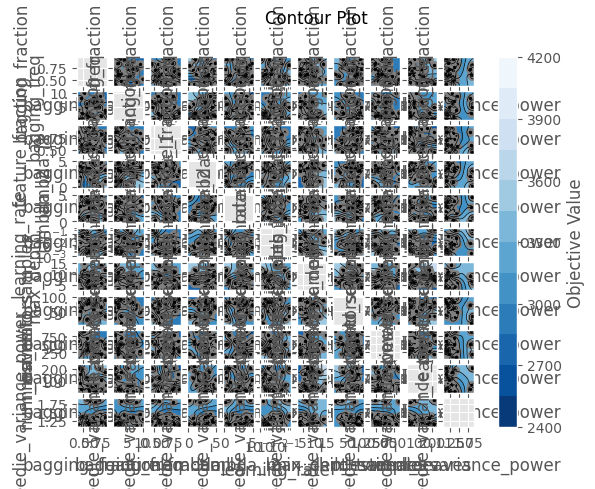

In [8]:
results = optimizer.run_study(X_train=X_train, y_train=y_train, X_val=X_val,y_val=y_val, 
                              study_name     = study_name,
                              features_names = cont_columns+cat_columns,
                              output_dir     = f"./output/tryanderror/xgboost/",
                              direction      = "minimize", 
                              metric         = "neg_mean_absolute_error",
                              save_study     = True,
                              patience       = 20,
                              scaler         = val_df["M_tot"])

In [9]:
model_params = results.best_params

In [10]:
model = MLTreeRegressor(model_type   = "xgboost",
                        device       = "cuda",
                        n_jobs       = 10,
                        model_params = model_params,
                        feat_names   = contfeats+catfeats,
                        verbose      = True)

train_model = model.fit(X_train=X_train, y_train=y_train)

Initializing xgboost model (device=cuda)...
Successfully initialized xgboost model
Fitting xgboost model with (2330357, 6) samples...
Successfully fitted xgboost model


In [11]:
y_pred = model.predict(X=X_val)

y_rescaled_test = y_val*val_df["M_tot"]
y_rescaled_pred = np.clip(y_pred, 0, None)*val_df["M_tot"]

# Evaluation
mse  = mean_squared_error(y_rescaled_test, y_rescaled_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_rescaled_test, y_rescaled_pred)
r2   = r2_score(y_rescaled_test, y_rescaled_pred)

print(f"Test MSE  : {mse:.4f}")
print(f"Test RMSE : {rmse:.4f}")
print(f"Test MAE  : {mae:.4f}")
print(f"Test R2   : {r2:.4f}")

Test MSE  : 15832353.9212
Test RMSE : 3978.9891
Test MAE  : 2463.5224
Test R2   : 0.7994


In [12]:
y_pred = model.predict(X=X_test)

y_rescaled_test = y_test*test_df["M_tot"]
y_rescaled_pred = np.clip(y_pred, 0, None)*test_df["M_tot"]

# Evaluation
mse  = mean_squared_error(y_rescaled_test, y_rescaled_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_rescaled_test, y_rescaled_pred)
r2   = r2_score(y_rescaled_test, y_rescaled_pred)

print(f"Test MSE  : {mse:.4f}")
print(f"Test RMSE : {rmse:.4f}")
print(f"Test MAE  : {mae:.4f}")
print(f"Test R2   : {r2:.4f}")

Test MSE  : 27963478.5432
Test RMSE : 5288.0505
Test MAE  : 4087.8650
Test R2   : 0.1611


In [20]:
from scipy.stats import ks_2samp

features = ["log(t)", "log(t_coll/t_cc)" ,"M_tot/M_crit", "log(rho(R_h))", "log(R_h/R_core)", "M_MMO/M_tot"]

for feature in features:
    stat, pval = ks_2samp(feats_train[feature], feats_test[feature])
    print(f"{feature} -  KS statistic={stat:.3f}, p-value={pval}")

log(t) -  KS statistic=0.420, p-value=0.0
log(t_coll/t_cc) -  KS statistic=0.220, p-value=0.0
M_tot/M_crit -  KS statistic=0.196, p-value=0.0
log(rho(R_h)) -  KS statistic=0.230, p-value=0.0
log(R_h/R_core) -  KS statistic=0.352, p-value=0.0
M_MMO/M_tot -  KS statistic=0.370, p-value=0.0
